In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc

In [10]:
adata = sc.read("/mnt/c/Users/sneha/BrainCellAtlas/data/human_mtg_brain_atlas_final.h5ad")
gene_list = pd.read_csv('/mnt/c/Users/sneha/OneDrive/Desktop/gene expression matrices human/genes-rows.csv')
target_genes = gene_list['gene'].tolist()
gene_present = [g 
                for g in target_genes if g in adata.raw.var_names] #check which genes are present in the dataframe ind
sc.settings.figdir = '../results/figures/'

language_keywords = ['FOXP2', 'CNTNAP2', 'ROBO', 'DYX', 'KIAA', 'DCDC2']
language_genes = [g for g in gene_present if any(keyword in g.upper() for keyword in language_keywords)]
print(f"Language-related genes found: {language_genes}")

Language-related genes found: ['KIAA0226L', 'KIAA1033', 'KIAA1147', 'KIAA1551', 'KIAA1598', 'KIAA1755', 'ROBO1', 'ROBO2']


In [11]:
def calculate_tau(expr_matrix):
    """Calculate tissue specificity index (Yanai et al. 2005)
    expr_matrix: rows = genes, columns = cell types
    """
    n = expr_matrix.shape[1]  # number of cell types
    if n == 1:
        return np.array([0])
    
    expr_max = expr_matrix.max(axis=1, keepdims=True)
    expr_max[expr_max == 0] = 1  # avoid division by zero
    
    expr_norm = 1 - (expr_matrix / expr_max)
    tau = expr_norm.sum(axis=1) / (n - 1)
    
    return tau

In [12]:
X = adata.raw[:, language_genes].X

# Convert sparse to dense if needed
if hasattr(X, 'toarray'):
    X = X.toarray()

expr_df = pd.DataFrame(
    X,
    columns=language_genes,
    index=adata.obs.index
)

In [13]:
expr_df['cell_type'] = adata.obs['class'].values  # Use 'class' for broad cell types

# Compute mean expression per cell type (cell_types x genes)
expr_by_type = expr_df.groupby('cell_type')[language_genes].mean()

print(f"\nExpression matrix shape: {expr_by_type.shape}")
print(f"Cell types: {expr_by_type.index.tolist()}")


Expression matrix shape: (4, 8)
Cell types: ['GABAergic', 'Glutamatergic', 'Non-neuronal', 'no class']


/tmp/ipykernel_57564/1780516363.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  expr_by_type = expr_df.groupby('cell_type')[language_genes].mean()


In [14]:
# Calculate tau for each gene
tau_scores = {}
for gene in language_genes:
    # Transpose so rows=genes, cols=cell types
    gene_expr = expr_by_type[gene].values.reshape(1, -1)
    tau = calculate_tau(gene_expr)
    tau_scores[gene] = tau[0]

In [15]:
# Create results DataFrame
specificity_df = pd.DataFrame({
    'gene': language_genes,
    'tau_score': [tau_scores[g] for g in language_genes],
    'max_celltype': [expr_by_type[g].idxmax() for g in language_genes],
    'max_expression': [expr_by_type[g].max() for g in language_genes]
})

specificity_df = specificity_df.sort_values('tau_score', ascending=False)
print("\nCell-type specificity results:")
print(specificity_df)



Cell-type specificity results:
        gene  tau_score   max_celltype  max_expression
5   KIAA1755   0.944323   Non-neuronal        0.417648
7      ROBO2   0.776580      GABAergic        1.090647
6      ROBO1   0.686117      GABAergic        0.682291
0  KIAA0226L   0.427020   Non-neuronal        0.140202
4   KIAA1598   0.212013      GABAergic        0.865582
3   KIAA1551   0.201645      GABAergic        0.485546
2   KIAA1147   0.193625  Glutamatergic        0.352398
1   KIAA1033   0.168376   Non-neuronal        0.589304


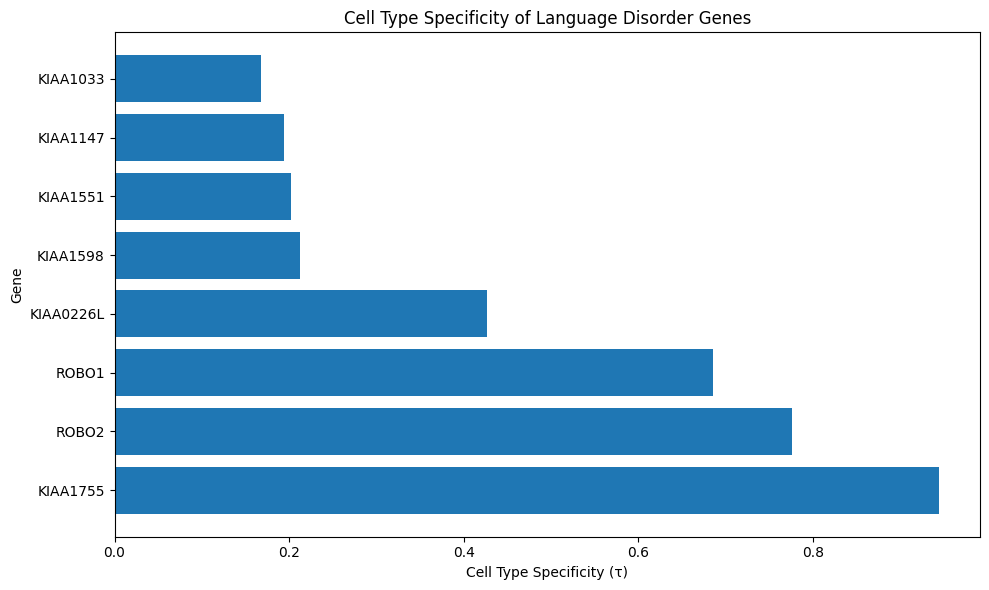

In [18]:
# 1. Tau specificity bar plot
plt.figure(figsize=(10, 6))
plt.barh(specificity_df['gene'], specificity_df['tau_score'])
plt.xlabel('Cell Type Specificity (τ)')
plt.ylabel('Gene')
plt.title('Cell Type Specificity of Language Disorder Genes')
plt.tight_layout()
#plt.savefig('../results/figures/language_genes_tau_specificity.pdf')


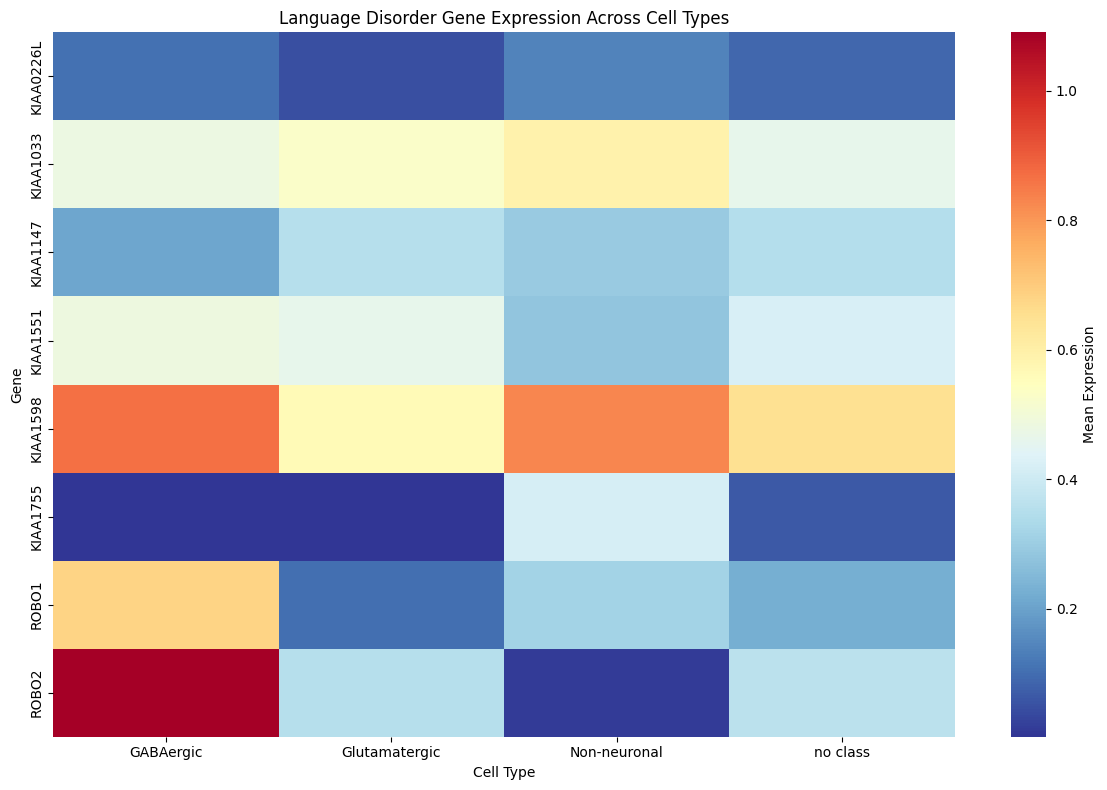

In [20]:
# 2. Heatmap of mean expression by cell type
plt.figure(figsize=(12, 8))
sns.heatmap(expr_by_type[language_genes].T, 
            cmap='RdYlBu_r', 
            cbar_kws={'label': 'Mean Expression'},
            xticklabels=True, yticklabels=True)
plt.title('Language Disorder Gene Expression Across Cell Types')
plt.xlabel('Cell Type')
plt.ylabel('Gene')
plt.tight_layout()
plt.savefig('../results/figures/language_genes_heatmap_by_celltype.pdf')

/tmp/ipykernel_57564/1619443686.py:6: FutureWarning: Argument `save` is deprecated and will be removed in a future version. Use `sc.pl.plot(show=False).figure.savefig()` instead.
  sc.pl.umap(adata, color=gene, use_raw=True, save=f'_{gene}_expression.pdf')


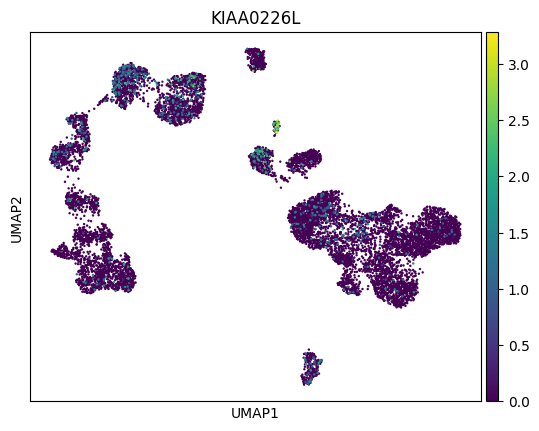

/tmp/ipykernel_57564/1619443686.py:6: FutureWarning: Argument `save` is deprecated and will be removed in a future version. Use `sc.pl.plot(show=False).figure.savefig()` instead.
  sc.pl.umap(adata, color=gene, use_raw=True, save=f'_{gene}_expression.pdf')


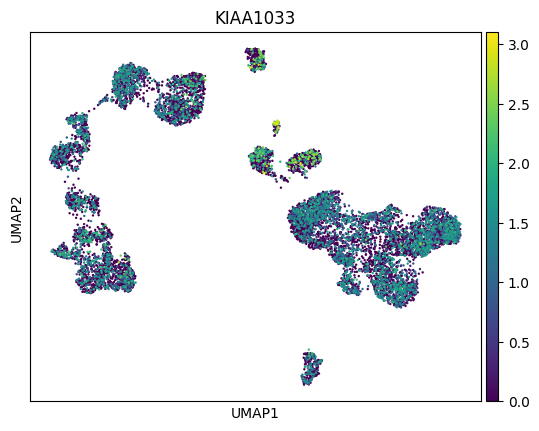

/tmp/ipykernel_57564/1619443686.py:6: FutureWarning: Argument `save` is deprecated and will be removed in a future version. Use `sc.pl.plot(show=False).figure.savefig()` instead.
  sc.pl.umap(adata, color=gene, use_raw=True, save=f'_{gene}_expression.pdf')


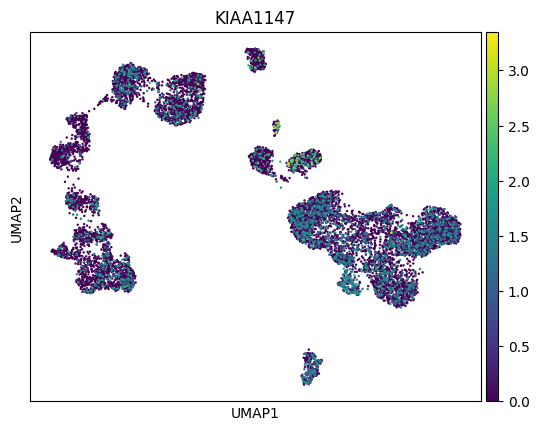

/tmp/ipykernel_57564/1619443686.py:6: FutureWarning: Argument `save` is deprecated and will be removed in a future version. Use `sc.pl.plot(show=False).figure.savefig()` instead.
  sc.pl.umap(adata, color=gene, use_raw=True, save=f'_{gene}_expression.pdf')


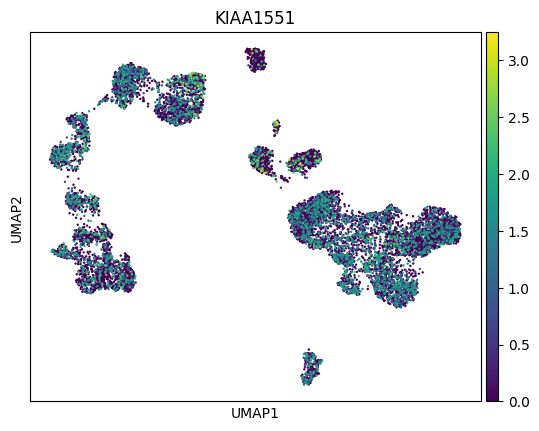

/tmp/ipykernel_57564/1619443686.py:6: FutureWarning: Argument `save` is deprecated and will be removed in a future version. Use `sc.pl.plot(show=False).figure.savefig()` instead.
  sc.pl.umap(adata, color=gene, use_raw=True, save=f'_{gene}_expression.pdf')


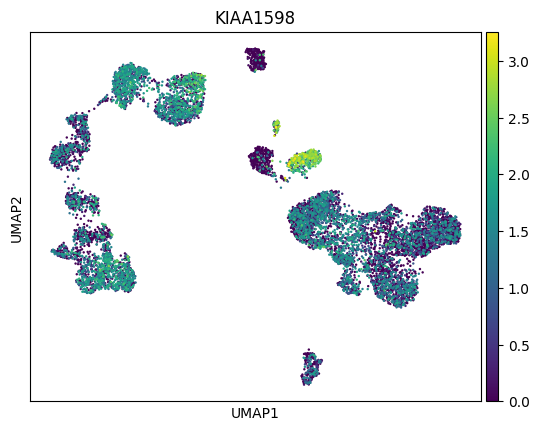

In [21]:
if 'X_umap' not in adata.obsm.keys():
    sc.pp.neighbors(adata, n_neighbors=15, n_pcs=25)
    sc.tl.umap(adata)

for gene in language_genes[:5]:
    sc.pl.umap(adata, color=gene, use_raw=True, save=f'_{gene}_expression.pdf')

/tmp/ipykernel_57564/4185371005.py:2: FutureWarning: Argument `save` is deprecated and will be removed in a future version. Use `sc.pl.plot(show=False).figure.savefig()` instead.
  sc.pl.dotplot(adata, var_names=language_genes, groupby='class',


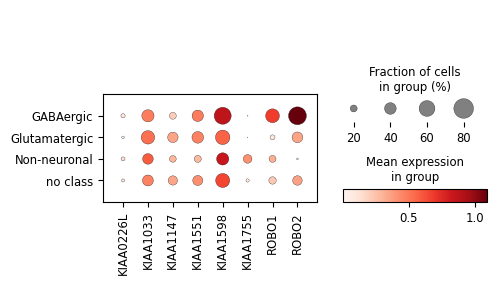

In [23]:
# 4. Dotplot
sc.pl.dotplot(adata, var_names=language_genes, groupby='class', 
              save='language_genes_dotplot_by_class.pdf')

In [25]:
specificity_df.to_csv('../results/language_genes_tau_specificity.csv', index=False)
expr_by_type.to_csv('../results/language_genes_mean_expression_by_celltype.csv')

print("Analysis complete! Check ../results/ for outputs")

Analysis complete! Check ../results/ for outputs
